# Assignment 3 - Capital Bikeshare Data

In [2]:
# load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNetCV, ElasticNet
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# Data Preparation

https://ride.capitalbikeshare.com/system-data

In [5]:
import pandas as pd
# Read csv files

df_Feb = pd.read_csv('Data/202402-capitalbikeshare-tripdata.csv')
df_Mar = pd.read_csv('Data/202403-capitalbikeshare-tripdata.csv')
df_Apr = pd.read_csv('Data/202404-capitalbikeshare-tripdata.csv')

# concat data
df=pd.concat([df_Feb, df_Mar,df_Apr])

In [6]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,24DBACC298E33BF6,electric_bike,2024-02-01 21:18:50,2024-02-01 21:27:36,Eckington Pl & Q St NE,31505.0,5th & K St NW,31600.0,38.910893,-77.005023,38.90304,-77.019027,member
1,FE1067800A18BC56,electric_bike,2024-02-06 17:15:33,2024-02-06 17:30:33,4th & C St SW,31243.0,NaN,NaN,38.886443,-77.017388,38.91000,-76.980000,member
2,AD1962B215B5879D,electric_bike,2024-02-26 13:19:42,2024-02-26 13:30:44,North Capitol St & F St NW,31624.0,NaN,NaN,38.896907,-77.009684,38.90000,-77.010000,member
3,3F8352E6D9EC4F85,electric_bike,2024-02-02 11:01:22,2024-02-02 11:05:14,1st & K St NE,31662.0,NaN,NaN,38.902394,-77.005614,38.90000,-77.010000,member
4,D656DA87FA915F14,electric_bike,2024-02-25 08:28:18,2024-02-25 08:48:44,Virginia Ave & 25th St NW,31297.0,NaN,NaN,38.898456,-77.053075,38.91000,-77.060000,member


## Let's consider the GWSB station "22nd & H St NW"

### Bike Availability: Number of Pickups

In [9]:
# Convert the 'started_at' column to datetime objects
df['started_at_date'] = pd.to_datetime(df['started_at']).dt.date

# Filter for trips started at '22nd & H St NW'
PU_trips = df[df['start_station_name'] == '22nd & H St NW']

# Group by date and count the trips
PU_counts = PU_trips.groupby('started_at_date')['started_at_date'].count()

PU_counts

started_at_date
2024-02-01    33
2024-02-02    23
2024-02-03    22
2024-02-04    18
2024-02-05    19
              ..
2024-04-26    33
2024-04-27    18
2024-04-28    36
2024-04-29    37
2024-04-30    40
Name: started_at_date, Length: 90, dtype: int64

### Dock Availability: Number of Dropoffs

In [11]:
# Convert the 'ended_at' column to datetime objects
df['ended_at_date'] = pd.to_datetime(df['ended_at']).dt.date

# Filter for trips ended at '22nd & H St NW'
DO_trips = df[df['end_station_name'] == '22nd & H St NW']

# Group by date and count the trips
DO_counts = DO_trips.groupby('ended_at_date')['ended_at_date'].count()

DO_counts

ended_at_date
2024-02-01    33
2024-02-02    25
2024-02-03    20
2024-02-04    19
2024-02-05    23
              ..
2024-04-26    39
2024-04-27    24
2024-04-28    28
2024-04-29    38
2024-04-30    39
Name: ended_at_date, Length: 90, dtype: int64

## Merge PU and DO tables
- For each day, we look at the numbers of pickups and dropoffs

In [13]:
# merge PU_counts and DO_counts by matching the dates, and change the column names to PU_count and DO_count respectively.

PU_DO_counts = pd.merge(PU_counts, DO_counts, left_index=True, right_index=True, how='outer')
PU_DO_counts = PU_DO_counts.rename(columns={'started_at_date': 'PU_ct', 'ended_at_date': 'DO_ct'})

# change the index name from 'started_at' to 'date'

PU_DO_counts = PU_DO_counts.rename_axis('date')
PU_DO_counts

,PU_ct,DO_ct
date,,
2024-02-01,33,33
2024-02-02,23,25
2024-02-03,22,20
2024-02-04,18,19
2024-02-05,19,23
...,...,...
2024-04-26,33,39
2024-04-27,18,24
2024-04-28,36,28


## Feature Information: Weather Data
- From https://www.visualcrossing.com/weather-history/

In [15]:
df_weather = pd.read_csv('Data/DC_weather_2024.csv')

df_weather.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"washington, dc",2024-01-01,43.0,38.9,40.8,41.8,31.4,36.4,33.3,74.7,...,0.9,1,10,2024-01-01T07:26:50,2024-01-01T16:56:30,0.68,Overcast,Cloudy skies throughout the day.,cloudy,"KDCA,72405013743,D6279,72403793728,KADW,KDAA,7..."
1,"washington, dc",2024-01-02,45.9,35.7,40.4,40.9,27.2,33.8,26.2,57.3,...,8.3,5,10,2024-01-02T07:26:58,2024-01-02T16:57:20,0.72,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KDCA,72405013743,D6279,72403793728,KADW,KDAA,7..."
2,"washington, dc",2024-01-03,47.8,33.7,39.9,44.6,27.8,36.4,26.6,59.5,...,9.6,5,10,2024-01-03T07:27:04,2024-01-03T16:58:10,0.75,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"C6294,KDCA,72405013743,D6279,72403793728,KADW,..."
3,"washington, dc",2024-01-04,46.7,33.2,40.4,41.9,24.1,34.6,25.2,55.2,...,4.8,4,10,2024-01-04T07:27:07,2024-01-04T16:59:02,0.78,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"C6294,KDCA,72405013743,72403793728,KADW,KDAA,7..."
4,"washington, dc",2024-01-05,39.9,27.8,33.6,35.8,19.4,28.0,18.9,55.0,...,11.6,5,10,2024-01-05T07:27:09,2024-01-05T16:59:55,0.81,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"C6294,KDCA,72405013743,72403793728,D6279,KADW,..."


## Drop variables of your choice

In [17]:
# Drop unnecessary variables
df_weather=df_weather.drop(columns=['name', 'stations','description','sunrise','sunset','conditions','severerisk','preciptype','windgust'])

## Prepare X and y: Merge df_weather with PU_DO_counts

In [19]:
# Convert the 'datetime' column to datetime objects and extract the date
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
df_weather['date'] = df_weather['datetime'].dt.date

# Merge the two dataframes based on the 'date' column
merged_df = pd.merge(PU_DO_counts, df_weather, on='date', how='left')

# Prepare training and test data

In [21]:
# we have two target variables: PU_ct and DO_ct
y = merged_df[['PU_ct','DO_ct']]
X_all = merged_df.drop(columns=['PU_ct','DO_ct']) # all features
X_all

,date,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,icon
0,2024-02-01,2024-02-01,53.0,31.7,42.4,53.0,26.4,39.3,34.0,74.0,...,12.0,190.8,1016.3,43.3,8.4,136.8,11.8,5,0.73,partly-cloudy-day
1,2024-02-02,2024-02-02,51.8,44.0,47.1,51.8,36.6,44.4,35.5,65.1,...,19.1,354.3,1012.8,97.3,9.8,51.7,4.4,2,0.75,rain
2,2024-02-03,2024-02-03,51.0,35.8,42.2,51.0,28.0,37.6,26.2,53.8,...,14.7,354.9,1018.2,11.0,9.9,143.9,12.5,6,0.79,clear-day
3,2024-02-04,2024-02-04,51.2,32.7,41.7,51.2,27.4,40.7,26.0,56.4,...,9.2,87.4,1016.0,9.0,9.9,147.4,12.8,6,0.83,clear-day
4,2024-02-05,2024-02-05,51.8,32.5,41.0,51.8,26.0,37.8,26.0,57.4,...,12.2,34.9,1013.8,21.4,9.9,145.3,12.7,6,0.86,partly-cloudy-day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2024-04-26,2024-04-26,64.9,45.5,55.2,64.9,41.5,54.2,34.9,50.8,...,15.4,116.4,1029.5,69.1,9.9,215.0,18.5,9,0.59,partly-cloudy-day
86,2024-04-27,2024-04-27,60.1,51.9,55.7,60.1,51.9,55.7,45.4,69.0,...,10.0,149.9,1030.1,97.3,9.7,44.0,3.9,2,0.63,rain
87,2024-04-28,2024-04-28,83.1,55.8,67.0,83.3,55.8,67.1,56.4,70.6,...,10.0,170.0,1021.3,62.1,9.8,213.6,18.5,9,0.67,partly-cloudy-day
88,2024-04-29,2024-04-29,88.3,62.7,75.2,88.9,62.7,75.3,60.9,63.5,...,13.0,177.3,1015.6,35.8,9.9,204.5,17.8,9,0.70,partly-cloudy-day


## Reduce dimensions by feature type

In [23]:
#dimentionality reduction: PCA
def dim_red(dataframe,lists,columnname):
    #extract the columns
    datagroup=dataframe.filter(lists)
    #normalize the data
    from sklearn.preprocessing import StandardScaler
    data_norm = StandardScaler().fit_transform(datagroup)
    #feature extraction with PCA
    from sklearn.decomposition import PCA
    pca = PCA(n_components=1)
    PCs = pca.fit_transform(datagroup)

    df_pca = pd.DataFrame(data = PCs, columns = [columnname])
    return df_pca

In [24]:
temp_group=['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike','dew']
precip_group=['humidity','precip', 'precipprob', 'precipcover']
vis_group=['visibility','solarradiation', 'solarenergy', 'uvindex']
wind_group=['windgust','windspeed', 'winddir']

In [25]:
temp_PC1=dim_red(X_all,temp_group,'temp_PC1')
precip_PC1=dim_red(X_all,precip_group,'precip_PC1')
vis_PC1=dim_red(X_all,vis_group,'vis_PC1')
wind_PC1=dim_red(X_all,wind_group,'wind_PC1')

## Dimension reduction on the features
- Now we call the following features X

In [27]:
X = pd.concat([temp_PC1,precip_PC1,vis_PC1,wind_PC1],axis = 1)
X

,temp_PC1,precip_PC1,vis_PC1,wind_PC1
0,-23.616810,-32.623727,4.466466,0.835152
1,-11.905681,62.494225,-80.995297,-162.790919
2,-26.760771,-36.797274,11.641535,-163.281210
3,-26.853470,-36.260085,15.152105,104.272810
4,-28.487066,-36.053473,13.052631,156.681869
...,...,...,...,...
85,7.209137,-37.417107,83.053732,75.127468
86,14.738853,63.300059,-88.705521,41.772262
87,47.863874,-33.326205,81.659100,21.678490
88,65.008395,-34.793145,72.539192,14.306077


In [28]:
# Combine PCA features and targets into one DataFrame
df_output = pd.concat([X, y], axis=1)

# Export to CSV
df_output.to_csv("bike_demand_PCA_features.csv", index=False)

# Confirm it worked
print("File saved as bike_demand_PCA_features.csv")


File saved as bike_demand_PCA_features.csv


# Exploratory Analysis

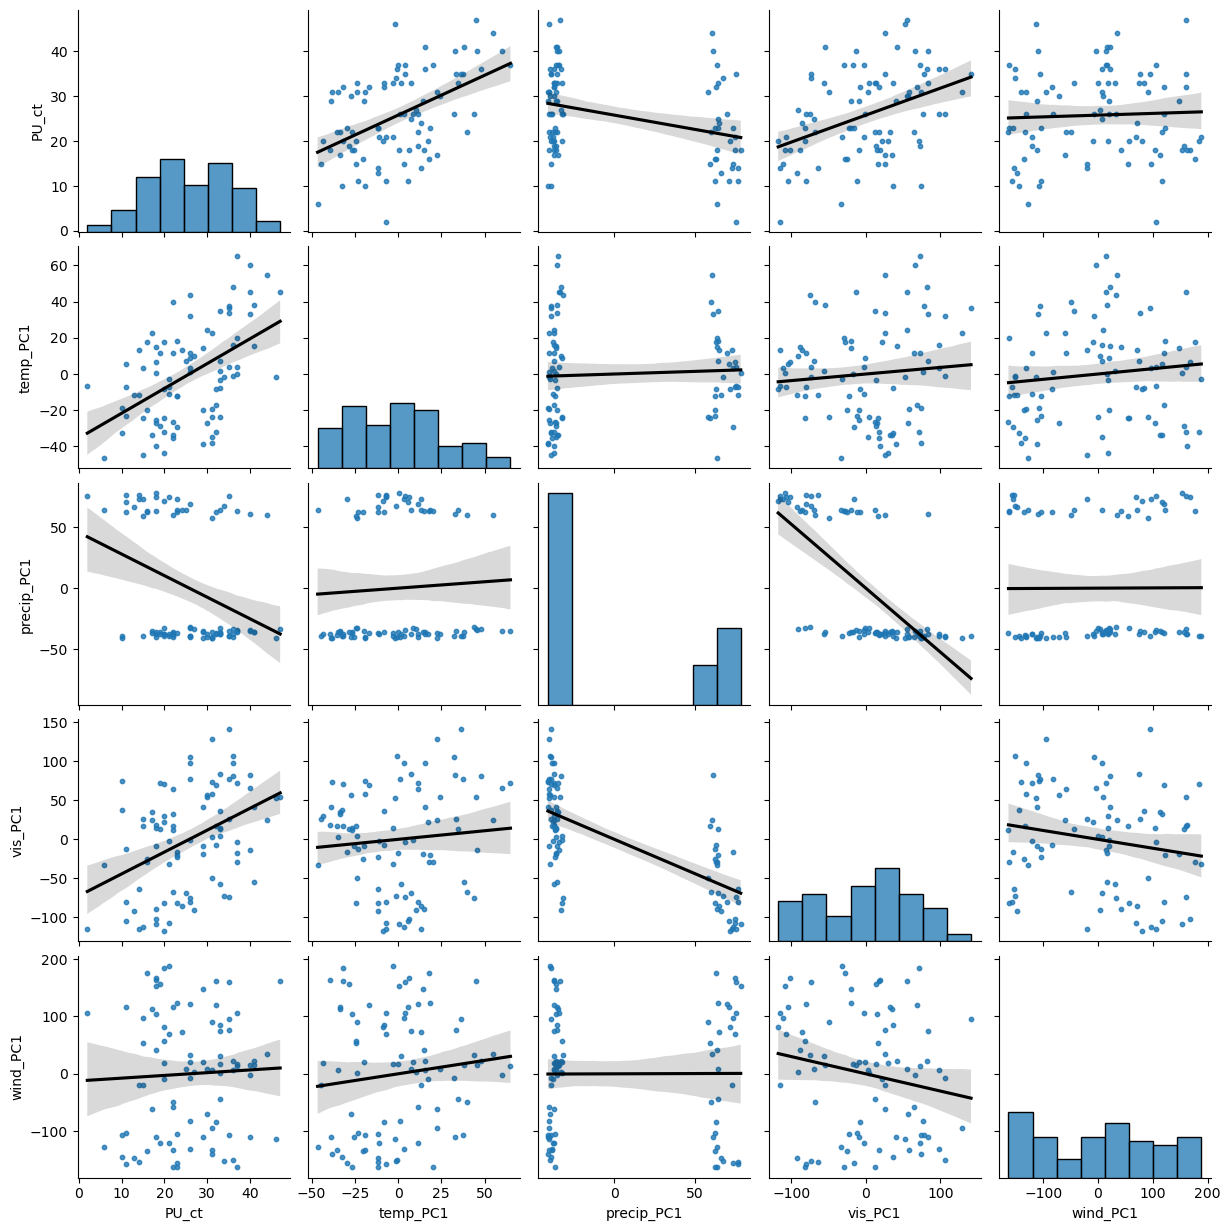

In [30]:
import seaborn as sns

# Prepare a PCA + PU_ct subset
df_pairplot = df_output[['PU_ct', 'temp_PC1', 'precip_PC1', 'vis_PC1', 'wind_PC1']]

# Plot
sns.pairplot(
    df_pairplot,
    kind="reg",
    plot_kws=dict(scatter_kws=dict(s=10), line_kws={'color': 'black'})
)

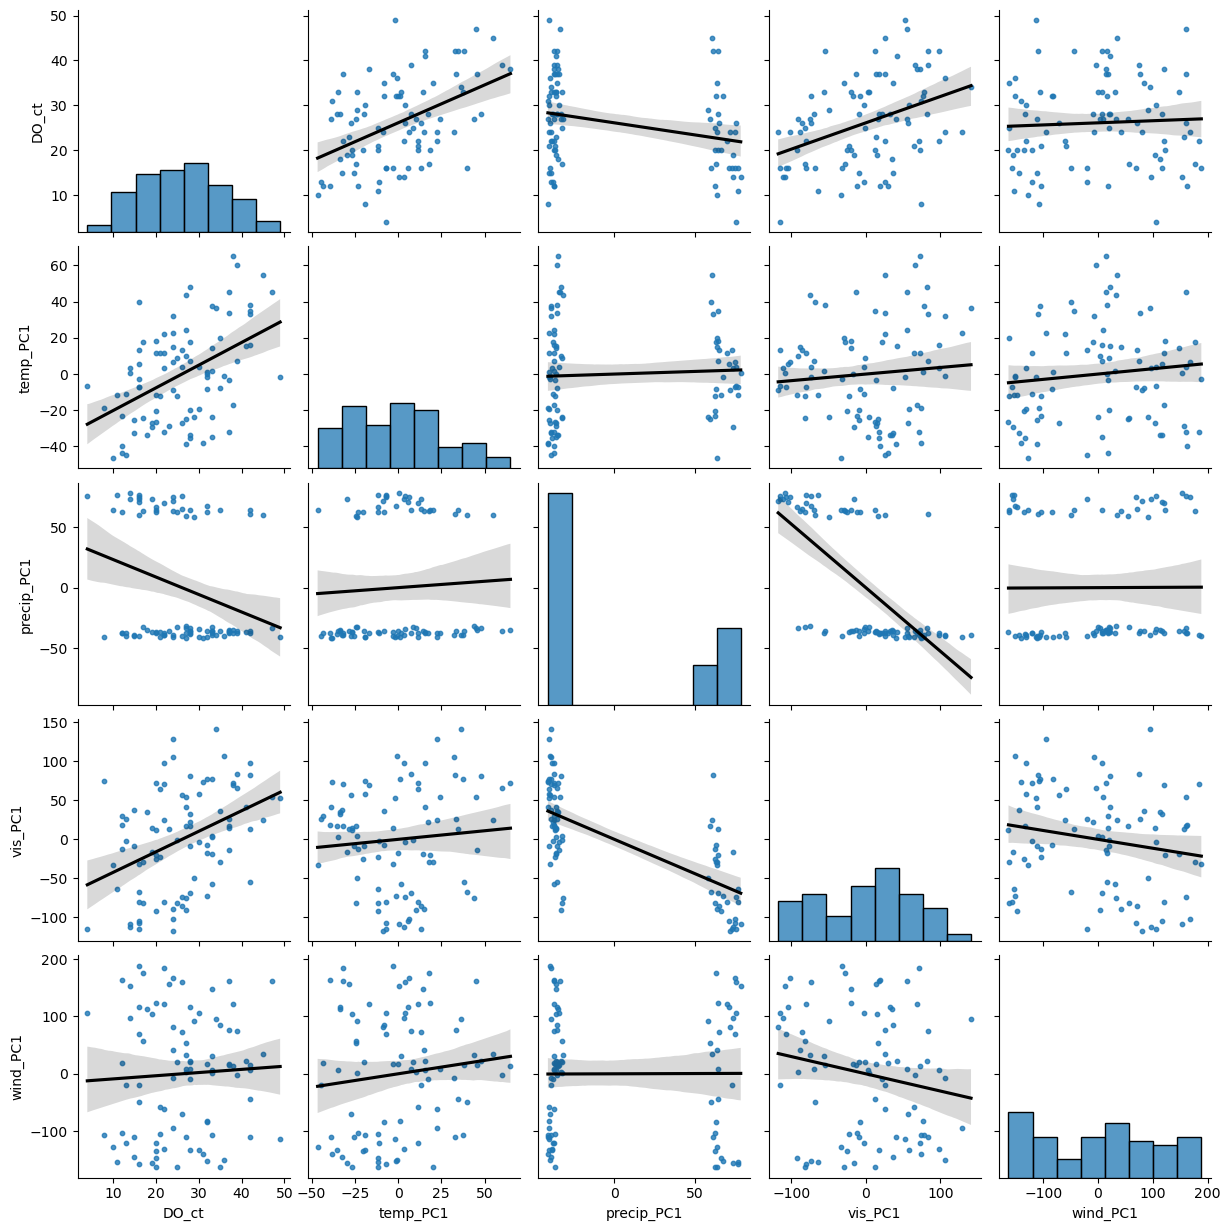

In [31]:
import seaborn as sns

# Prepare a PCA + DO_ct subset
df_pairplot = df_output[['DO_ct', 'temp_PC1', 'precip_PC1', 'vis_PC1', 'wind_PC1']]

# Plot
sns.pairplot(
    df_pairplot,
    kind="reg",
    plot_kws=dict(scatter_kws=dict(s=10), line_kws={'color': 'black'})
)

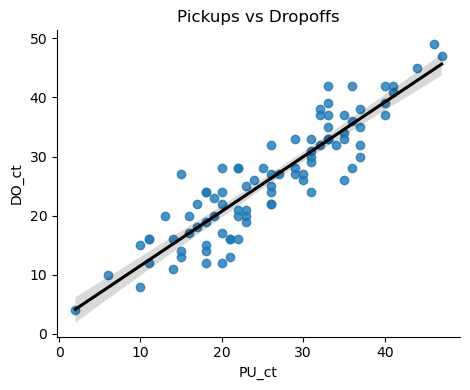

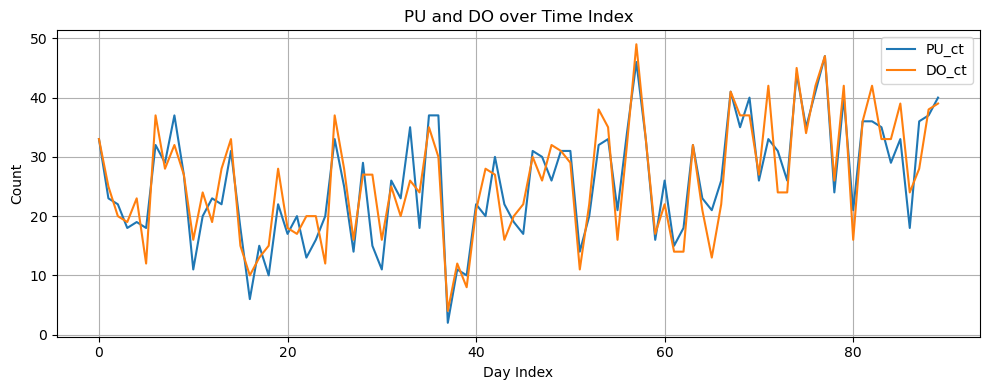

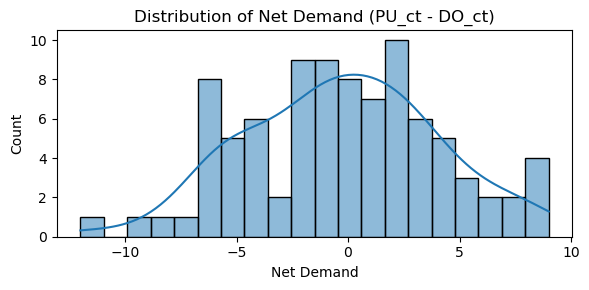

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Scatterplot: PU vs DO
sns.lmplot(data=df_output, x='PU_ct', y='DO_ct',
           line_kws={"color": "black"}, height=4, aspect=1.2)
plt.title("Pickups vs Dropoffs")
plt.xlabel("PU_ct")
plt.ylabel("DO_ct")
plt.tight_layout()
plt.show()

# 2. Lineplot: PU and DO over Time Index
plt.figure(figsize=(10, 4))
sns.lineplot(x=range(len(df_output)), y='PU_ct', data=df_output, label='PU_ct')
sns.lineplot(x=range(len(df_output)), y='DO_ct', data=df_output, label='DO_ct')
plt.title("PU and DO over Time Index")
plt.xlabel("Day Index")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Net Demand Histogram
df_output['net_demand'] = df_output['PU_ct'] - df_output['DO_ct']
plt.figure(figsize=(6, 3))
sns.histplot(df_output['net_demand'], kde=True, bins=20)
plt.title("Distribution of Net Demand (PU_ct - DO_ct)")
plt.xlabel("Net Demand")
plt.tight_layout()
plt.show()


### 1. PU vs DO Relationship

- The scatterplot with regression line shows a strong positive correlation between pickups and dropoffs (nearly linear).
- This suggests that most days have balanced activity, and modeling one could help predict the other.
- However, as seen in the line plot, there is some day-to-day fluctuation where pickups and dropoffs diverge — which is operationally relevant.

### 2. Net Demand Distribution

- The net demand histogram (PU_ct - DO_ct) shows a roughly symmetric but slightly left-skewed distribution.
- This implies that dropoffs slightly outnumber pickups on some days, which may cause dock capacity issues more often than bike shortages.

### 3. Pairplots – Weather PCA Features vs PU/DO

**PU_ct vs PCA Features:**
- temp_PC1 shows a moderate positive trend: warmer temperatures lead to more pickups.
- precip_PC1 has a negative relationship: more precipitation reduces pickups.
- vis_PC1 (visibility/solar index) shows positive correlation: better visibility and solar conditions boost demand.
- wind_PC1 is noisy, but weakly positive—could suggest moderate wind doesn’t discourage riders.

**DO_ct vs PCA Features:**
- The same overall patterns hold with DO_ct, but relationships are slightly weaker, especially with wind and precipitation.
- This suggests pickup behavior is more sensitive to weather than dropoff behavior—likely because people can choose to not begin a trip if the weather is bad.

# Predictive Modeling

In [37]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train,y_test = train_test_split(X,y, test_size=0.4, random_state = 200) # 40% test data

In [38]:
y_train.head()

,PU_ct,DO_ct
73,26,24
60,26,22
18,10,15
44,19,20
4,19,23


## Linear Regression

In [40]:
# 1. Fit Linear Regression on both targets
lr = LinearRegression()
lr.fit(X_train, y_train)

# 2. Predict on the test set
y_pred_test = lr.predict(X_test)

# 3. Wrap predictions into Series for cost calculation
pu_preds_lr = pd.Series(y_pred_test[:, 0], index=y_test.index)
do_preds_lr = pd.Series(y_pred_test[:, 1], index=y_test.index)

# 4. Calculate test-set MSE for each target
mse_pu_lr = mean_squared_error(y_test['PU_ct'], y_pred_test[:, 0])
mse_do_lr = mean_squared_error(y_test['DO_ct'], y_pred_test[:, 1])

print(f"Test MSE (PU_ct): {mse_pu_lr:.2f}")
print(f"Test MSE (DO_ct): {mse_do_lr:.2f}")

Test MSE (PU_ct): 55.58
Test MSE (DO_ct): 69.55


## LASSO

In [42]:
alphas = np.logspace(-4, 2, 50)
for target in ['PU_ct', 'DO_ct']:
    # 1. Find best alpha using cross-validation
    lassocv = LassoCV(alphas=alphas, cv=5, random_state=0)
    lassocv.fit(X_train, y_train[target])
    best_alpha = lassocv.alpha_
    print(f"Best α for {target}: {best_alpha:.3f}")
    
    # 2. Fit Lasso with selected alpha
    lasso = Lasso(alpha=best_alpha, random_state=0)
    lasso.fit(X_train, y_train[target])
    
    # 3. Predict and evaluate
    y_pred_test = lasso.predict(X_test)
    mse = mean_squared_error(y_test[target], y_pred_test)
    print(f"MSE ({target}): {mse:.2f}\n")
    
    # 4. Store predictions as Series for cost evaluation
    if target == 'PU_ct':
        pu_preds_lasso = pd.Series(y_pred_test, index=y_test.index)
        mse_pu_lasso = mse
    else:
        do_preds_lasso = pd.Series(y_pred_test, index=y_test.index)
        mse_do_lasso = mse



Best α for PU_ct: 24.421
MSE (PU_ct): 57.83

Best α for DO_ct: 42.919
MSE (DO_ct): 71.31



## Ridge Regression 

In [44]:
alphas = np.logspace(-4, 2, 50)
for target in ['PU_ct', 'DO_ct']:
    # a) Use RidgeCV to pick the best α via 5-fold CV
    ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=5)
    ridgecv.fit(X_train, y_train[target])
    best_alpha = ridgecv.alpha_
    print(f"Best α for {target}: {best_alpha:.3f}")
    
    # b) Fit Ridge model with the best α
    ridge = Ridge(alpha=best_alpha)
    ridge.fit(X_train, y_train[target])
    
    # c) Predict and calculate MSE
    y_pred_test = ridge.predict(X_test)
    mse = mean_squared_error(y_test[target], y_pred_test)
    print(f"MSE ({target}): {mse:.2f}\n")
    
    # d) Store predictions as Series
    if target == 'PU_ct':
        pu_preds_ridge = pd.Series(y_pred_test, index=y_test.index)
        mse_pu_ridge = mse
    else:
        do_preds_ridge = pd.Series(y_pred_test, index=y_test.index)
        mse_do_ridge = mse


Best α for PU_ct: 100.000
MSE (PU_ct): 55.57

Best α for DO_ct: 100.000
MSE (DO_ct): 69.54



## Elastic Net

In [46]:
alphas = np.logspace(-4, 2, 50)
for target in ['PU_ct', 'DO_ct']:
    # ElasticNetCV with 10-fold CV
    encv = ElasticNetCV(alphas=alphas, cv=10, max_iter=10000, random_state=0)
    encv.fit(scale(X_train), y_train[target])
    
    print(f"The best alpha for {target} from ElasticNetCV: {encv.alpha_:.3f}")
    
    # Fit final ElasticNet model
    enet = ElasticNet(alpha=encv.alpha_, l1_ratio=0.5, max_iter=10000, random_state=0)
    enet.fit(scale(X_train), y_train[target])
    
    # Predict
    y_pred_test = enet.predict(scale(X_test))
    mse = mean_squared_error(y_test[target], y_pred_test)
    print(f"MSE ({target}): {mse:.2f}\n")
    
    # Store predictions as Series
    if target == 'PU_ct':
        pu_preds_enet = pd.Series(y_pred_test, index=y_test.index)
        mse_pu_enet = mse
    else:
        do_preds_enet = pd.Series(y_pred_test, index=y_test.index)
        mse_do_enet = mse

The best alpha for PU_ct from ElasticNetCV: 0.202
MSE (PU_ct): 55.26

The best alpha for DO_ct from ElasticNetCV: 0.356
MSE (DO_ct): 67.89



## KNN

In [48]:
# Define the range of k values to try
param_grid = {'n_neighbors': list(range(1, 21))}
best_k_values = {}

for target in ['PU_ct', 'DO_ct']:
    # Use GridSearchCV to find the best k
    knn = KNeighborsRegressor()
    grid = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid.fit(X_train, y_train[target])

    # Save best k
    best_k = grid.best_params_['n_neighbors']
    best_k_values[target] = best_k
    print(f"Best k for {target}: {best_k}")

    # Fit and predict
    best_knn = KNeighborsRegressor(n_neighbors=best_k)
    best_knn.fit(X_train, y_train[target])
    y_pred_test = best_knn.predict(X_test)

    mse = mean_squared_error(y_test[target], y_pred_test)
    print(f"KNN MSE ({target}): {mse:.2f}\n")

    # Store predictions as Series
    if target == 'PU_ct':
        pu_preds_knn = pd.Series(y_pred_test, index=y_test.index)
        mse_pu_knn = mse
    else:
        do_preds_knn = pd.Series(y_pred_test, index=y_test.index)
        mse_do_knn = mse

Best k for PU_ct: 12
KNN MSE (PU_ct): 66.51

Best k for DO_ct: 14
KNN MSE (DO_ct): 72.63



## Regression Tree

In [50]:
# Define range of max_depth values
param_grid = {'max_depth': list(range(1, 21))}

# Storage
pu_preds_tree = None
do_preds_tree = None
best_depths = {}

for target in ['PU_ct', 'DO_ct']:
    # GridSearch for best depth
    tree = DecisionTreeRegressor(random_state=0)
    grid = GridSearchCV(tree, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid.fit(X_train, y_train[target])

    best_depth = grid.best_params_['max_depth']
    best_depths[target] = best_depth
    print(f"Best max_depth for {target}: {best_depth}")

    # Fit with best depth
    best_tree = DecisionTreeRegressor(max_depth=best_depth, random_state=0)
    best_tree.fit(X_train, y_train[target])

    # Predict
    y_pred_test = best_tree.predict(X_test)
    mse = mean_squared_error(y_test[target], y_pred_test)
    print(f"Decision Tree MSE ({target}): {mse:.2f}\n")

    # Store predictions
    if target == 'PU_ct':
        pu_preds_tree = pd.Series(y_pred_test, index=y_test.index)
        mse_pu_tree = mse
    else:
        do_preds_tree = pd.Series(y_pred_test, index=y_test.index)
        mse_do_tree = mse


Best max_depth for PU_ct: 3
Decision Tree MSE (PU_ct): 133.40

Best max_depth for DO_ct: 1
Decision Tree MSE (DO_ct): 95.93



## Random Forest

In [52]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None]
}

# Storage
pu_preds_rf = None
do_preds_rf = None
best_rf_params = {}

for target in ['PU_ct', 'DO_ct']:
    rf = RandomForestRegressor(random_state=0)
    grid = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train[target])

    best_params = grid.best_params_
    best_rf_params[target] = best_params
    print(f"Best Random Forest params for {target}: {best_params}")

    # Fit and predict
    best_rf = RandomForestRegressor(**best_params, random_state=0)
    best_rf.fit(X_train, y_train[target])
    y_pred_test = best_rf.predict(X_test)
    mse = mean_squared_error(y_test[target], y_pred_test)
    print(f"Random Forest MSE ({target}): {mse:.2f}\n")

    # Store predictions
    if target == 'PU_ct':
        pu_preds_rf = pd.Series(y_pred_test, index=y_test.index)
        mse_pu_rf = mse
    else:
        do_preds_rf = pd.Series(y_pred_test, index=y_test.index)
        mse_do_rf = mse


Best Random Forest params for PU_ct: {'max_depth': 3, 'n_estimators': 100}
Random Forest MSE (PU_ct): 73.24

Best Random Forest params for DO_ct: {'max_depth': 3, 'n_estimators': 100}
Random Forest MSE (DO_ct): 89.88



## Gradient Boosting

In [54]:
# Parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Storage
pu_preds_gbr = None
do_preds_gbr = None
best_gbr_params = {}

for target in ['PU_ct', 'DO_ct']:
    gbr = GradientBoostingRegressor(random_state=0)
    grid = GridSearchCV(gbr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train[target])

    best_params = grid.best_params_
    best_gbr_params[target] = best_params
    print(f"Best GBR params for {target}: {best_params}")

    # Fit and predict
    best_gbr = GradientBoostingRegressor(**best_params, random_state=0)
    best_gbr.fit(X_train, y_train[target])
    y_pred_test = best_gbr.predict(X_test)
    mse = mean_squared_error(y_test[target], y_pred_test)
    print(f"Gradient Boosting MSE ({target}): {mse:.2f}\n")

    # Store predictions
    if target == 'PU_ct':
        pu_preds_gbr = pd.Series(y_pred_test, index=y_test.index)
        mse_pu_gbr = mse
    else:
        do_preds_gbr = pd.Series(y_pred_test, index=y_test.index)
        mse_do_gbr = mse

Best GBR params for PU_ct: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}
Gradient Boosting MSE (PU_ct): 92.25

Best GBR params for DO_ct: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200}
Gradient Boosting MSE (DO_ct): 103.12



## Neural Network

In [56]:
# Define hyperparameter grid
param_grid = {
    'hidden_layer_sizes': [(32,), (64,), (32, 32), (64, 64)],
    'alpha': [0.0001, 0.001, 0.01]
}

# Storage
pu_preds_nn = None
do_preds_nn = None
best_nn_params = {}

for target in ['PU_ct', 'DO_ct']:
    # Initialize model with higher max_iter and early stopping
    mlp = MLPRegressor(max_iter=3000, early_stopping=True, random_state=0)
    grid = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train[target])

    best_params = grid.best_params_
    best_nn_params[target] = best_params
    print(f"Best NN params for {target}: {best_params}")

    # Refit model with best parameters
    best_mlp = MLPRegressor(**best_params, max_iter=3000, early_stopping=True, random_state=0)
    best_mlp.fit(X_train, y_train[target])

    # Predict and evaluate
    y_pred_test = best_mlp.predict(X_test)
    mse = mean_squared_error(y_test[target], y_pred_test)
    print(f"Neural Network MSE ({target}): {mse:.2f}\n")

    # Store predictions
    if target == 'PU_ct':
        pu_preds_nn = pd.Series(y_pred_test, index=y_test.index)
        mse_pu_nn = mse
    else:
        do_preds_nn = pd.Series(y_pred_test, index=y_test.index)
        mse_do_nn = mse

Best NN params for PU_ct: {'alpha': 0.0001, 'hidden_layer_sizes': (64,)}
Neural Network MSE (PU_ct): 81.91

Best NN params for DO_ct: {'alpha': 0.0001, 'hidden_layer_sizes': (64,)}
Neural Network MSE (DO_ct): 117.72



# Performance Evaluation 


    Evaluates total and average decision cost based on predicted and actual PU/DO counts.

    Args:
        pu_preds (array or Series): Predicted pick-up counts
        do_preds (array or Series): Predicted drop-off counts
        y_test (DataFrame): True values with columns ['PU_ct', 'DO_ct']
        alpha (int): Cost per unsuccessful pick-up
        beta (int): Cost per unsuccessful drop-off
        capacity (int): Total number of bikes + docks to allocate

    Returns:
        avg_cost (float): Average daily cost
        total_cost (float): Total out-of-sample cost
        allocations (list of tuples): Optimal (x, y) allocations for each day


In [141]:
def evaluate_cost(pu_preds, do_preds, y_test, alpha=2, beta=3, capacity=34):
    total_costs = []
    x_values = []

    for i in range(len(y_test)):
        min_cost = float('inf')
        optimal_x, optimal_y = None, None

        for x in range(capacity + 1):
            y = capacity - x
            cost_pred = alpha * max(0, pu_preds.iloc[i] - x) + beta * max(0, do_preds.iloc[i] - y)
            if cost_pred < min_cost:
                min_cost = cost_pred
                optimal_x, optimal_y = x, y

        actual_cost = alpha * max(0, y_test['PU_ct'].iloc[i] - optimal_x) + \
                      beta * max(0, y_test['DO_ct'].iloc[i] - optimal_y)

        total_costs.append(actual_cost)
        x_values.append(optimal_x)  # store x for each test day

    avg_cost = np.mean(total_costs)
    return avg_cost, x_values


In [143]:
# Evaluate cost for each model
avg_cost_lr, x_lr = evaluate_cost(pu_preds_lr,     do_preds_lr,     y_test)
avg_cost_lasso, x_lasso = evaluate_cost(pu_preds_lasso,  do_preds_lasso,  y_test)
avg_cost_ridge, _ridge = evaluate_cost(pu_preds_ridge,  do_preds_ridge,  y_test)
avg_cost_enet, x_enet = evaluate_cost(pu_preds_enet,   do_preds_enet,   y_test)
avg_cost_knn, x_knn = evaluate_cost(pu_preds_knn,    do_preds_knn,    y_test)
avg_cost_tree, x_tree = evaluate_cost(pu_preds_tree,   do_preds_tree,   y_test)
avg_cost_rf, x_rf = evaluate_cost(pu_preds_rf,     do_preds_rf,     y_test)
avg_cost_gbr, x_gbr = evaluate_cost(pu_preds_gbr,    do_preds_gbr,    y_test)
avg_cost_nn, x_nn = evaluate_cost(pu_preds_nn,     do_preds_nn,     y_test)

In [145]:
# Dictionary of results
model_results = {
    'Linear Regression':     (avg_cost_lr, mse_pu_lr, mse_do_lr),
    'Lasso':                 (avg_cost_lasso, mse_pu_lasso, mse_do_lasso),
    'Ridge':                 (avg_cost_ridge, mse_pu_ridge, mse_do_ridge),
    'ElasticNet':            (avg_cost_enet, mse_pu_enet, mse_do_enet),
    'KNN':                   (avg_cost_knn, mse_pu_knn, mse_do_knn),
    'Decision Tree':         (avg_cost_tree, mse_pu_tree, mse_do_tree),
    'Random Forest':         (avg_cost_rf, mse_pu_rf, mse_do_rf),
    'Gradient Boosting':     (avg_cost_gbr, mse_pu_gbr, mse_do_gbr),
    'Neural Network':        (avg_cost_nn, mse_pu_nn, mse_do_nn),
}

# Print formatted summary table 
print(f"{'Model':<20} {'MSE PU_ct':>12} {'MSE DO_ct':>12} {'Avg Cost':>10}")
print("-" * 58)
for model, (cost, mse_pu, mse_do) in model_results.items():
    print(f"{model:<20} {mse_pu:12.2f} {mse_do:12.2f} {cost:10.2f}")


Model                   MSE PU_ct    MSE DO_ct   Avg Cost
----------------------------------------------------------
Linear Regression           55.58        69.55      43.22
Lasso                       57.83        71.31      43.03
Ridge                       55.57        69.54      43.22
ElasticNet                  55.26        67.89      43.17
KNN                         66.51        72.63      43.08
Decision Tree              133.40        95.93      43.19
Random Forest               73.24        89.88      43.67
Gradient Boosting           92.25       103.12      43.86
Neural Network              81.91       117.72      45.39


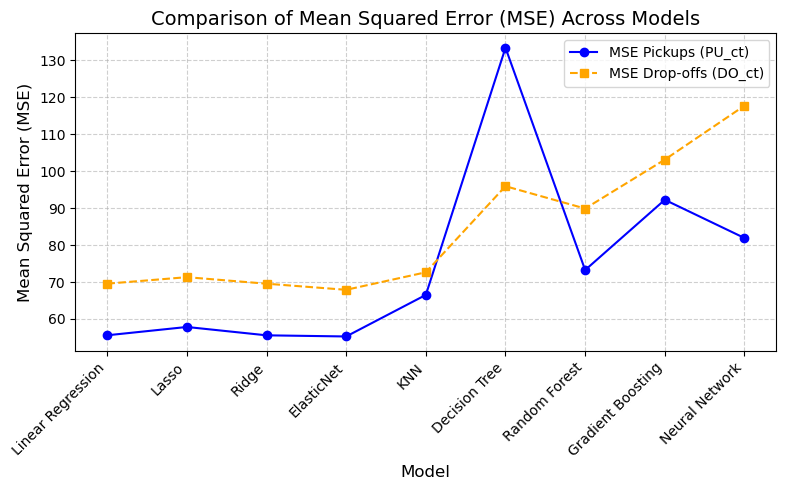

In [155]:
# Model names and corresponding MSE values
models = ['Linear Regression', 'Lasso', 'Ridge', 'ElasticNet', 'KNN',
          'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Neural Network']

mse_pu = [55.58, 57.83, 55.57, 55.26, 66.51, 133.40, 73.24, 92.25, 81.91]
mse_do = [69.55, 71.31, 69.54, 67.89, 72.63, 95.93, 89.88, 103.12, 117.72]

# Plotting MSE for each model
plt.figure(figsize=(8, 5))
plt.plot(models, mse_pu, marker='o', linestyle='-', color='blue', label='MSE Pickups (PU_ct)')
plt.plot(models, mse_do, marker='s', linestyle='--', color='orange', label='MSE Drop-offs (DO_ct)')

# Customizing the plot
plt.title('Comparison of Mean Squared Error (MSE) Across Models', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()


In [147]:
# Dictionary of average x allocations
x_allocations = {
    'Linear Regression':     np.mean(x_lr),
    'Lasso':                 np.mean(x_lasso),
    'Ridge':                 np.mean(x_ridge),
    'ElasticNet':            np.mean(x_enet),
    'KNN':                   np.mean(x_knn),
    'Decision Tree':         np.mean(x_tree),
    'Random Forest':         np.mean(x_rf),
    'Gradient Boosting':     np.mean(x_gbr),
    'Neural Network':        np.mean(x_nn),
}

# Print table
print(f"{'Model':<20} {'Avg Bikes Allocated (x)':>25}")
print("-" * 45)
for model, avg_x in x_allocations.items():
    print(f"{model:<20} {avg_x:25.2f}")


Model                  Avg Bikes Allocated (x)
---------------------------------------------
Linear Regression                         7.08
Lasso                                     7.08
Ridge                                     2.00
ElasticNet                                7.42
KNN                                       6.94
Decision Tree                             8.61
Random Forest                             6.67
Gradient Boosting                         6.94
Neural Network                            9.36


***Generative AI tools, including ChatGPT, were used to assist with code development, data analysis, and the drafting of this notebook and report. All outputs were reviewed and modified to ensure accuracy, originality, and alignment with course guidelines.**